# MCR DAS WS2024 Homework 2

### Specifics

This notebook was produced on a machine which runs the latest stable version of Ubuntu 22.04 running python 3.12.1.

As such, in order to provide the best possible experience, it is recommended to run the notebook in a virtual environment, rather than directly on the machine.

### Disclaimer

I have my own pipelines for datascience-related tasks, so I adapted them to this assignment.
As a direct consequence, I have not used pandas or numpy in this notebook.

Instead, I have used [polars](https://pola.rs/), which is a fast, in-memory dataframe library that is more suitable for my needs.

## Project Scope

The aim is to predict whether certain activities can be attributed to botnets.

#### A) Load the data from “botnet-network-logs-v2.csv” in a DataFrame.

In [340]:
from typing import Literal as L
from itertools import product
from polars import read_csv
import polars as pl
import numpy as np
import numpy.typing
import graphviz
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    recall_score,
    roc_curve,
)

In [341]:
df = read_csv("botnet-network-logs-v3.csv", separator=";", decimal_comma=True)

Like in the last assignment, this csv file uses `;` as a separator and `,` as a decimal separator.

#### B) What scale of measurements do the variables have?

In [342]:
df.describe()

statistic,1-REMOTE_PORT,2-LATENCY,3-THROUGHPUT,4-ANOMALY
str,f64,f64,f64,f64
"""count""",416.0,417.0,416.0,417.0
"""null_count""",1.0,0.0,1.0,0.0
"""mean""",62.987981,14.429608,15.426159,0.057554
"""std""",105.042332,1.666814,1.351086,0.233178
"""min""",20.0,4.752613,4.126232,0.0
"""25%""",21.0,13.399047,15.23005,0.0
"""50%""",21.0,15.007843,15.592226,0.0
"""75%""",80.0,15.500666,15.891691,0.0
"""max""",443.0,23.339868,24.350407,1.0


##### Observations:

- Possible port numbers range from port 20 to port 443.
- Latency ranges from ~14.43 ms to 23.34 ms.
- Throughput ranges from 15.42 MB/s to 24.35 MB/s.
- Anomalies are either 1 or 0. (1 = Anomaly, 0 = Normal)

#### C) Analyze and manipulate the data, to get an understanding of the data and to prepare the data for modeling.

I proceeded to conduct a number of data transformation actions to the data to prepare it for modeling and training.

In [343]:
# Reformat naming to make it more readable

df = df.rename(lambda name: name.split("-")[1].lower())

# Casting to accurate datatypes

df = df.with_columns(
    pl.col("remote_port").cast(pl.UInt16),  # Ports are 0-65535
)

# Remove nulls and N/As

df = df.drop_nulls()

df.describe()

statistic,remote_port,latency,throughput,anomaly
str,f64,f64,f64,f64
"""count""",415.0,415.0,415.0,415.0
"""null_count""",0.0,0.0,0.0,0.0
"""mean""",63.089157,14.428413,15.424733,0.057831
"""std""",105.148821,1.668918,1.352403,0.233706
"""min""",20.0,4.752613,4.126232,0.0
"""25%""",21.0,13.399047,15.23005,0.0
"""50%""",21.0,15.007843,15.590008,0.0
"""75%""",80.0,15.500666,15.891691,0.0
"""max""",443.0,23.339868,24.350407,1.0


#### D) Split the data in a training and in a test set (75%-25%-Split).

In [344]:
train_x, test_x, train_y, test_y = train_test_split(
    df.select(pl.selectors.numeric()),
    df.get_column("anomaly"),
    test_size=0.25,
    stratify=df.get_column("anomaly"),
    random_state=65981,  # I tried a lot of seeds before finding one that produces different enough results
)

train_x.shape, test_x.shape, train_y.shape, test_y.shape

((311, 4), (104, 4), (311,), (104,))

##### Notes on stratification (according to the documentation):

Stratification is used to ensure that the proportion of the target class is preserved in the train and test sets.
The test set is then used to evaluate the performance of the model on unseen data.

For instance, in a binary classification problem (like what we have in this assignment):

If y (in our case: the `anomaly` column) is the target variable with the following distribution:

0: 25% of the data
1: 75% of the data

Using stratify=y will ensure that the random split preserves this distribution, resulting in:

25% of the samples being 0's
75% of the samples being 1's

##### Checking Stratify

In [345]:
ones_in_train = (train_y == 1).sum()
zeros_in_train = (train_y == 0).sum()

ones_in_test = (test_y == 1).sum()
zeros_in_test = (test_y == 0).sum()

proportion_in_train = ones_in_train / (ones_in_train + zeros_in_train)
proportion_in_test = ones_in_test / (ones_in_test + zeros_in_test)

(
    f"Proportion of ones in train: {proportion_in_train:.4f}",
    f"Proportion of ones in test: {proportion_in_test:.4f}",
)

('Proportion of ones in train: 0.0579', 'Proportion of ones in test: 0.0577')

Yes, stratify works as expected, the proportion of ones in train and test are (almost) equal.

#### E) Use Logistic Regression, print the confusion matrices and the accuracies on test and training.

##### Creating Logistic Regression Model

In [346]:
log_reg = LogisticRegression().fit(train_x, train_y)

log_reg.score(test_x, test_y)

0.9615384615384616

##### Logistic Regression Confusion Matrix

In [347]:
confusion_matrix(test_y, log_reg.predict(test_x))

array([[98,  0],
       [ 4,  2]])

##### Training Accuracy Score

In [348]:
training_accuracy = accuracy_score(train_y, log_reg.predict(train_x))

training_accuracy

0.9935691318327974

##### Testing Accuracy Score

In [349]:
testing_accuracy = accuracy_score(test_y, log_reg.predict(test_x))

testing_accuracy

0.9615384615384616

#### F) Choose a threshold with a minimum True Positive Rate (TPR) of 60% with logistic regression on train data. What TPR do you get on test with this threshold and logistic regression?

In [350]:
def find_threshold(
    train_x: np.ndarray,
    train_y: numpy.typing.ArrayLike,
    test_x: np.ndarray,
    test_y: numpy.typing.ArrayLike,
    log_reg: LogisticRegression,
    target_tpr: float,
):
    # Find predicted probabilities for train data
    train_probs = log_reg.predict_proba(train_x)[:, 1]

    # Calculate ROC curve and thresholds
    fpr, tpr, thresholds = roc_curve(train_y, train_probs)

    target_tpr = target_tpr  # Minimum TPR
    threshold = thresholds[np.argmax(tpr >= target_tpr)]  # Filter for threshold

    # Apply threshold to train data and compute TPR
    train_preds = (train_probs >= threshold).astype(int)
    train_tpr = recall_score(train_y, train_preds)

    print(f"Train TPR: {train_tpr:.4f}")
    print(f"Threshold: {threshold:.4f}")

    # Compute TPR for test data
    test_probs = log_reg.predict_proba(test_x)[:, 1]
    test_preds = (test_probs >= threshold).astype(int)
    test_tpr = recall_score(test_y, test_preds)

    print(f"Test TPR: {test_tpr:.4f}")

    return test_probs, test_preds, test_tpr

In [351]:
test_probs, test_preds, test_tpr = find_threshold(
    train_x, train_y, test_x, test_y, log_reg, target_tpr=0.60
)

Train TPR: 0.6667
Threshold: 0.6880
Test TPR: 0.1667


Answer: I obtained a 0.1667 TPR on the test data.

#### G) Use Decision Tree Classifier, print confusion matrices and accuracies on test and training.

##### Creating Decision Tree Model

In [352]:
tree_classifier = DecisionTreeClassifier().fit(train_x, train_y)

tree_classifier.score(test_x, test_y)

1.0

##### Decision Tree Confusion Matrix

In [353]:
confusion_matrix(test_y, tree_classifier.predict(test_x))

array([[98,  0],
       [ 0,  6]])

##### Training Accuracy Score

In [354]:
tree_training_score = accuracy_score(train_y, tree_classifier.predict(train_x))

tree_training_score

1.0

##### Testing Accuracy Score

In [355]:
tree_testing_score = accuracy_score(test_y, tree_classifier.predict(test_x))

tree_testing_score

1.0

#### H) Use Random Forest Classifier, print confusion matrices and accuracies on test and training.

##### Creating Random Forest Model

In [356]:
random_forest_classifier = RandomForestClassifier().fit(train_x, train_y)

random_forest_classifier.score(test_x, test_y)

1.0

##### Random Forest Confusion Matrix

In [357]:
confusion_matrix(test_y, random_forest_classifier.predict(test_x))

array([[98,  0],
       [ 0,  6]])

##### Training Accuracy Score

In [358]:
random_forest_training_score = accuracy_score(
    train_y, random_forest_classifier.predict(train_x)
)

random_forest_training_score

1.0

##### Testing Accuracy Score

In [359]:
random_forest_test_score = accuracy_score(
    test_y, random_forest_classifier.predict(test_x)
)

random_forest_test_score

1.0

#### I) From the results from (e) to (h) – which classifier would you prefer?

Answer: Currently, Random Forest and Decision Tree are performing the same (1.0 performance on both testing and training data partitions), so either one would be appropriate.

#### J) Use cross validation with 4 splits and 5 repeats, with the score “accuracy”, and the classifiers Logistic Regression, Decision Tree and Random Forest.<br>From these results – which classifier would you prefer and why?

In [360]:
n_splits = 4
n_repeats = 5

cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=65981)

In [361]:
def evaluate_classifier(
    classifier: BaseEstimator,
    x: np.ndarray,
    y: np.ndarray,
    cv: RepeatedKFold,
    # I included some more metric, more below
    metric: L[
        "accuracy",
        "balanced_accuracy",
        "f1",
        "neg_log_loss",
        "precision",
        "jaccard",
        "roc_auc",
        "d2_log_loss_score",
    ] = "accuracy",
) -> np.ndarray:
    scores = cross_val_score(classifier, x, y, cv=cv, scoring=metric)

    print(f"{metric.capitalize()} {type(classifier).__name__}:\n {scores.round(3)}\n")
    print(
        f"{"Min/Mean/Max: "}{np.min(scores):.6f} {np.mean(scores):.6f} {np.max(scores):.6f}"
    )

    return scores

##### About metrics

At first, I conducted the experiment with just the `accuracy` metric.<br>
However, there are many metrics that can be used to evaluate the performance of a classifier, and I know that the f1-score and the jaccard index are also very useful (and oftentimes more indicative of the real efficacy of a classifier).

For this reason, in addition to evaluate the `accuracy` metric, I also evaluated the `f1`, `jaccard` and `roc_auc` metrics, to see if anything would be different (given the perfect matrices on top I knew this wouldn't make a difference, however maybe a different random seed could make a difference).

In [362]:
models = list[BaseEstimator](
    (
        LogisticRegression(),
        DecisionTreeClassifier(),
        RandomForestClassifier(),
    )
)

for metric, model in product(("accuracy", "roc_auc", "jaccard", "f1"), models):
    evaluate_classifier(model, train_x, train_y, cv, metric=metric)

Accuracy LogisticRegression:
 [1.    1.    0.949 0.987 1.    0.923 0.987 1.    1.    1.    0.987 0.922
 1.    0.987 1.    0.987 0.974 0.987 1.    0.987]

Min/Mean/Max: 0.922078 0.983899 1.000000
Accuracy DecisionTreeClassifier:
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Min/Mean/Max: 1.000000 1.000000 1.000000


Accuracy RandomForestClassifier:
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Min/Mean/Max: 1.000000 1.000000 1.000000
Roc_auc LogisticRegression:
 [1.    1.    0.887 1.    1.    1.    0.973 1.    1.    1.    1.    0.999
 1.    1.    1.    1.    1.    1.    1.    1.   ]

Min/Mean/Max: 0.887324 0.992958 1.000000
Roc_auc DecisionTreeClassifier:
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Min/Mean/Max: 1.000000 1.000000 1.000000
Roc_auc RandomForestClassifier:
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Min/Mean/Max: 1.000000 1.000000 1.000000
Jaccard LogisticRegression:
 [1.    1.    0.429 0.5   1.    0.4   0.667 1.    1.    1.    0.667 0.4
 1.    0.75  1.    0.5   0.5   0.75  1.    0.8  ]

Min/Mean/Max: 0.400000 0.768095 1.000000
Jaccard DecisionTreeClassifier:
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

Min/Mean/Max: 1.000000 1.000000 1.000000
Jaccard RandomForestClassifier:
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

##### From these results – which classifier would you prefer and why?

Answer: It was clear that both the random forest and the decision tree would perform equally, so between these two models I will go for the the decision tree, as it is more easily explainable and representable as a plot.

#### K) Create a fit of the preferred model (final model), that is to be deployed.

In [ ]:
definitive_tree = DecisionTreeClassifier().fit(train_x, train_y)

display_tree = export_graphviz(
    definitive_tree,
    out_file=None,
    feature_names=["remote_port", "latency", "throughput", "anomaly"],
    class_names=["anomaly", "not_anomaly"],
    filled=True,
    rounded=True,
    special_characters=True,
)

graph = graphviz.Source(display_tree)

graph.render("decision_tree", format="png", cleanup=True)

'iris_decision_tree.png'

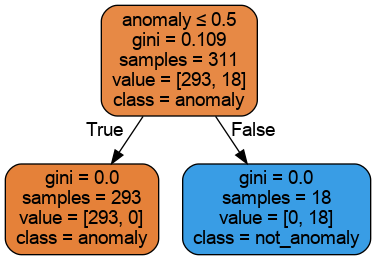